## Data Science Model Evaluation Sample

### Part 1: Exploratory Data Analysis

Approach: 
- check for duplicates in provided csv files
- load into local postgres database 
    - this part was done using postico, sql script will be included separately
- use sql and pandas for tabulation

In [1]:
import pandas as pd
import psycopg2

In [2]:
# initialize db connection object
conn = psycopg2.connect(host='localhost', 
                        database='cpl',
                        user='ratulesrar')

# using postico, I loaded both the DMH.csv and Sheriff.csv files into postgres tables called persons and arrests respectively
# see eda_ddl.sql for the relevant table expressions

In [3]:
# check for duplicates 
persons = pd.read_sql('select * from dmh.persons', conn)
arrests = pd.read_sql('select * from dmh.arrests', conn)

# persons[persons.duplicated()] 
# no duplicates found in dmh dataset

arrests[arrests.duplicated()]['arrest_date']

108      2016-12-15
395      2018-05-07
1580     2018-07-15
2556     2018-08-03
3047     2017-11-06
5332     2017-05-03
6759     2015-01-28
7513     2017-07-10
11040    2015-07-20
11589    2017-07-12
12464    2018-03-06
12865    2018-02-19
17123    2016-02-15
17505    2016-05-23
Name: arrest_date, dtype: object

Off the bat, I observed that there are 52,843 unique records in the DMH dataset and 17,989 unique records in the Sheriff dataset. I found 14 instances of multiple arrests for the same $person\_id$ on the same day. Based on some preliminary research on google, it seems like that happens frequently enough to suggest these same-day arrests could happen within reason. I chose not to remove these because I could not confidently assume the records to be duplicates. 

### (a) Grouped by homeless status, show the percentage of clients who had an arrest prior to their first DMH visit date.
9.7% of the clients who had an arrest prior to their first DMH visit did not enter a homeless shelter in the 12 months following their first DMH visit, while 3.3% did enter a homeless shelter in the 12 months following.

In [4]:
# eda part a
q1 = """
select homeless,
       sum(prior_arrest) as arrest_count, 
       sum(cast(prior_arrest as float)) / (select count(*) from dmh.persons) as prior_arrest_rate
from (
    select p.person_id,
    homeless,
    case
    when first_arrest_date < dmh_visit_date then 1 else 0
    end as prior_arrest
    from dmh.persons p
    left join (select person_id,
              min(arrest_date) as first_arrest_date 
              from dmh.arrests 
              group by person_id) a 
on a.person_id = p.person_id) sub
group by homeless;
"""

homeless_rates = pd.read_sql(q1, conn)
homeless_rates

,homeless,arrest_count,prior_arrest_rate
0,0,5158,0.097610
1,1,1736,0.032852


While the table above shows the rates, this is how I arrived at these numbers. First, I observed there are 52,843 clients in dataset and 7,230 of these clients had an arrest at any point (13.7% of clients). 6,894 clients had an arrest prior to their first DMH visit (13% of clients), so only 0.7% of clients had an arrest after their first DMH visit, which is pretty striking. Then I grouped this subset by the homeless shelter variable and found 9.7% of the clients who had an arrest prior to their first DMH visit did not enter a homeless shelter in the 12 months following their first DMH visit, while 3.3% did enter a homeless shelter in the 12 months following. If given more time, I believe a sankey diagram could display these findings in a visually compelling way. 

### (b) Conditional on being arrested, show the minimum, maximum, and average number of days between a client’s first DMH visit and their most recent arrest prior to that visit, grouped by race/ethnicity.
In the table below, I display the minimum, maximum, and average number of days between a client's first DMH visit and their most recent arrest prior to that visit, broken out by race/ethnicity. Of the 6,894 clients who had an arrest prior to their first visit, roughly 70% were Black or Latinx so these groups are most likely overrepresented in the arrest records. On average, it took at least 14.5 months (based on 439 days) to have a first DMH visit after an arrest. 

In [5]:
# eda part b
q2 = """
select race,
       min(days_between) as min_days_between,
       max(days_between) as max_days_between,
       avg(days_between) as avg_days_between,
       count(race) as n
from (
    select p.person_id,
       arrest_date,
       race,
       (dmh_visit_date - arrest_date) as days_between,
       row_number() over (partition by p.person_id order by arrest_date desc) as recency_rank
    from dmh.arrests a
    left join dmh.persons p on a.person_id = p.person_id
    where arrest_date < dmh_visit_date) sub
where recency_rank = 1
group by race;
"""

recent_arrest_summary = pd.read_sql(q2, conn)
recent_arrest_summary

,race,min_days_between,max_days_between,avg_days_between,n
0,Black,1,1419,439.743210,3240
1,Latinx,2,1392,451.724755,1733
2,Other,1,1394,473.958611,749
3,White,1,1387,460.502560,1172


If given more time, I believe a horizontal box plot could display the distribution of days between first DMH visit and most recent prior arrest cut by race. 
Some notes on the query used to generate the table above:
- Using rank() and dense_rank() was giving me a result that counted the same arrest day twice and I could not figure out why 
- I kept getting a result that showed 5 clients had multiple arrests on the same day prior to first DMH visit (1174, 36769, 37909, 22318, 51423) but they did not have duplicate arrests on those days when looking at just the arrests table
- Instead, I used row_number() to get around this issue which worked since I was ordering by arrest_date 

### (c) Show the number of clients who were arrested on two or more consecutive days at any point in their arrest history.
Based on the query below, I observed that 23 clients had a recorded arrest on consecutive days while 14 potentially had a second arrest on the same day, those these 14 could be duplicate entries. The 23 clients had arrests recorded on two consecutive days, but I did not observe anyone who had an arrest on more than two consecutive days. This could be due to external factors, but my working assumption is that the person was held longer after their second arrest in as many days for posing a threat to the public or themselves, though who really knows with law enforcement. 

In [6]:
# eda part c
q3 = """
select arrest_date,
       prev_arrest_date,
       (arrest_date - prev_arrest_date) as days_between_arrest,
       case when (arrest_date - prev_arrest_date) = 1 then 1 else 0 end as consecutive_arrest
from (
    select person_id,
           lag(arrest_date, 1) over (partition by person_id order by arrest_date) as prev_arrest_date,
           arrest_date
    from dmh.arrests) a
where prev_arrest_date is not null
order by consecutive_arrest desc;
"""

consecutive_arrests = pd.read_sql(q3, conn)
consecutive_arrests[(consecutive_arrests['consecutive_arrest'] == 1) | (consecutive_arrests['days_between_arrest'] == 0)]

,arrest_date,prev_arrest_date,days_between_arrest,consecutive_arrest
0,2018-12-05,2018-12-04,1,1
1,2016-09-12,2016-09-11,1,1
2,2017-04-01,2017-03-31,1,1
3,2018-01-03,2018-01-02,1,1
4,2018-03-17,2018-03-16,1,1
5,2015-06-07,2015-06-06,1,1
6,2018-01-24,2018-01-23,1,1
7,2015-06-19,2015-06-18,1,1
8,2017-04-06,2017-04-05,1,1
9,2015-06-24,2015-06-23,1,1


The table above shows persons with consecutive and same-day arrests, and this is how I arrived at these numbers. There were 18,003 total records in the arrests data between beginning of 2015 through the end of 2018. 7,230 clients have a recorded arrest in the dataset, 5,114 of whom have more than 1 arrest record. Of these individuals, 23 clients had a recorded arrest on consecutive days while 14 potentially had a second arrest on the same day (could be a duplicate). 0 clients had an arrest on more than two consecutive days and I included some thoughts around this above. 

### Part 2: Model Evaluation

Approach: 
- select intervention strategy
- calculate model evaluation metrics given prediction probabilities and outcomes
- select best model based on intervention strategy and provide recommendations

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, roc_curve, roc_auc_score, auc

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 8.5)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams.update({'axes.titlesize': '35'})
plt.style.use('fivethirtyeight')

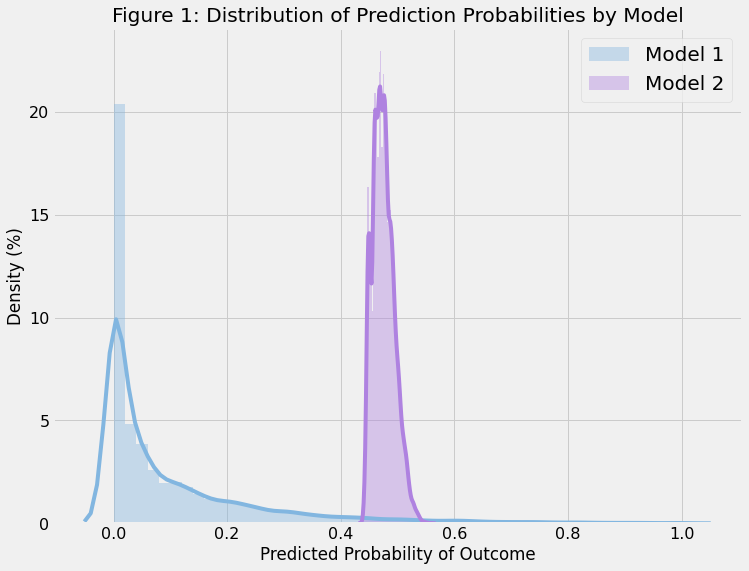

In [9]:
# visualize density of predictions by the two models
p1 = sns.distplot(persons['m1_pred_prob'], color='#82b6e0', label='Model 1')
p1 = sns.distplot(persons['m2_pred_prob'], color='#af82e0', label='Model 2')
plt.legend()
plt.ylabel('Density (%)')
plt.xlabel('Predicted Probability of Outcome')
plt.title('Figure 1: Distribution of Prediction Probabilities by Model')
plt.savefig('p1.png')

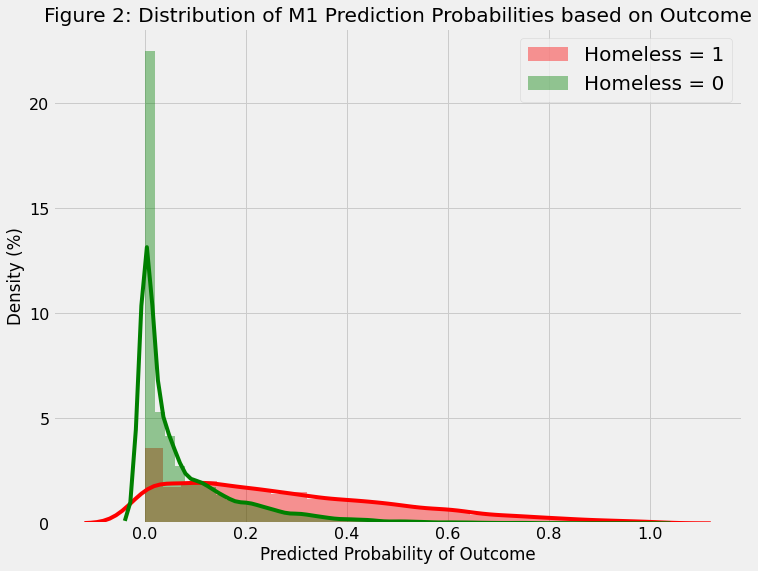

In [10]:
# visualize density of predictions based on outcome for model 1
homeless = persons[persons['homeless'] == 1]
not_homeless = persons[persons['homeless'] == 0]

sns.distplot(homeless['m1_pred_prob'], color='r', label='Homeless = 1', hist=True)
sns.distplot(not_homeless['m1_pred_prob'], color='g', label='Homeless = 0', hist=True)

plt.legend()
plt.ylabel('Density (%)')
plt.xlabel('Predicted Probability of Outcome')
plt.title('Figure 2: Distribution of M1 Prediction Probabilities based on Outcome')
plt.savefig('p2.png')

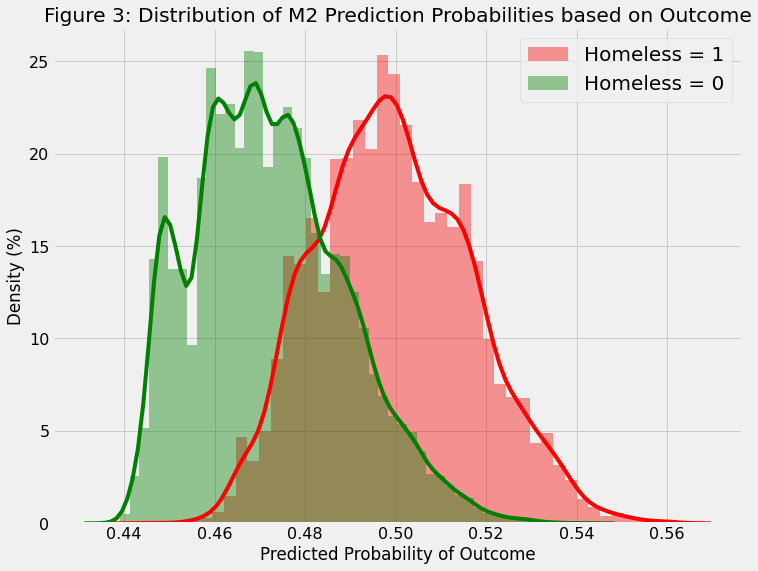

In [11]:
# visualize density of predictions based on outcome for model 2
sns.distplot(homeless['m2_pred_prob'], color='r', label='Homeless = 1', hist=True)
sns.distplot(not_homeless['m2_pred_prob'], color='g', label='Homeless = 0', hist=True)

plt.legend()
plt.ylabel('Density (%)')
plt.xlabel('Predicted Probability of Outcome')
plt.title('Figure 3: Distribution of M2 Prediction Probabilities based on Outcome')
plt.savefig('p3.png')

Since the provided dataset used  for model validation has over 50k records, roughly the top 1% yielded the 500 highest-risk individuals. Because resources are limited, it is best to optimize for precision at 1% because this metric minimizes the rate of false positives.

In [12]:
# want to find the m1_pred_prob at the top 1% of the distribution to set the treshold value
q = 1 - (500 / len(persons))
threshold1 = persons['m1_pred_prob'].quantile(q)
persons['m1_pred'] = persons['m1_pred_prob'].apply(lambda x: 1 if x > threshold1 else 0) 

In [13]:
tn = confusion_matrix(persons['homeless'], persons['m1_pred'])[0][0]
fp = confusion_matrix(persons['homeless'], persons['m1_pred'])[0][1]
fn = confusion_matrix(persons['homeless'], persons['m1_pred'])[1][0]
tp = confusion_matrix(persons['homeless'], persons['m1_pred'])[1][1]
confusion_matrix(persons['homeless'], persons['m1_pred'])

array([[46313,    91],
       [ 6030,   409]])

In [14]:
accuracy_score(persons['homeless'], persons['m1_pred'])

0.8841663039570047

In [15]:
precision1 = tp/(tp + fp)
precision1

0.818

In [16]:
recall1 = tp/(tp + fn)
recall1

0.06351917999689392

In [17]:
f1_1 = (2 * precision1 * recall1)/(precision1 + recall1)
f1_1

0.1178844213863669

Text(0.5, 1.0, 'Model 1 Confusion Matrix')

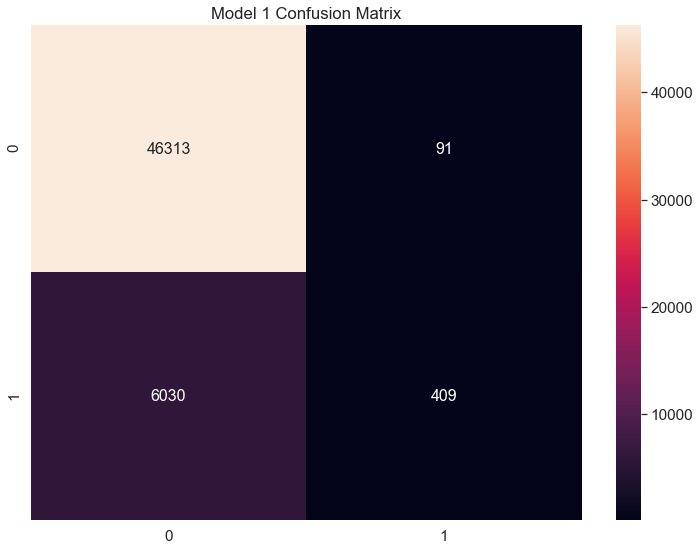

In [18]:
cm1 = pd.DataFrame(confusion_matrix(persons['homeless'], persons['m1_pred']), range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm1, annot=True, annot_kws={'size': 16}, fmt='d') # font size
plt.title('Model 1 Confusion Matrix')

Random Guess: ROC AU C= 0.500
Model 1: ROC AUC = 0.811


Text(0.5, 1.0, 'Model 1 AUC-ROC = 0.811')

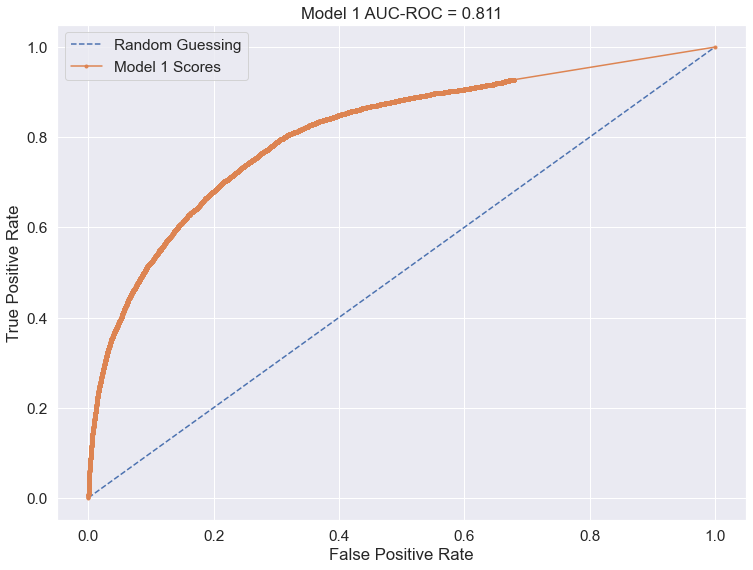

In [19]:
# calculate scores
ns_auc = roc_auc_score(persons['homeless'], [0 for _ in range(len(persons['homeless']))])
m1_auc = roc_auc_score(persons['homeless'], persons['m1_pred_prob'])

# summarize scores
print('Random Guess: ROC AU C= %.3f' % (ns_auc))
print('Model 1: ROC AUC = %.3f' % (m1_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(persons['homeless'], [0 for _ in range(len(persons['homeless']))])
m1_fpr, m1_tpr, _ = roc_curve(persons['homeless'], persons['m1_pred_prob'])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Guessing')
plt.plot(m1_fpr, m1_tpr, marker='.', label='Model 1 Scores')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend and title
plt.legend()
plt.title('Model 1 AUC-ROC = %.3f' % (m1_auc))

In [20]:
# want to find the m2_pred_prob at the top 1% of the distribution to set the treshold value
threshold2 = persons['m2_pred_prob'].quantile(q)
persons['m2_pred'] = persons['m2_pred_prob'].apply(lambda x: 1 if x > threshold2 else 0) 

In [21]:
tn = confusion_matrix(persons['homeless'], persons['m2_pred'])[0][0]
fp = confusion_matrix(persons['homeless'], persons['m2_pred'])[0][1]
fn = confusion_matrix(persons['homeless'], persons['m2_pred'])[1][0]
tp = confusion_matrix(persons['homeless'], persons['m2_pred'])[1][1]
confusion_matrix(persons['homeless'], persons['m2_pred'])

array([[46339,    65],
       [ 6004,   435]])

In [22]:
accuracy_score(persons['homeless'], persons['m2_pred'])

0.8851503510398728

In [23]:
precision2 = tp/(tp + fp)
precision2

0.87

In [24]:
recall2 = tp/(tp + fn)
recall2

0.06755707407982606

In [25]:
f1_2 = (2 * precision2 * recall2)/(precision2 + recall2)
f1_2

0.12537829658452226

Text(0.5, 1.0, 'Model 2 Confusion Matrix')

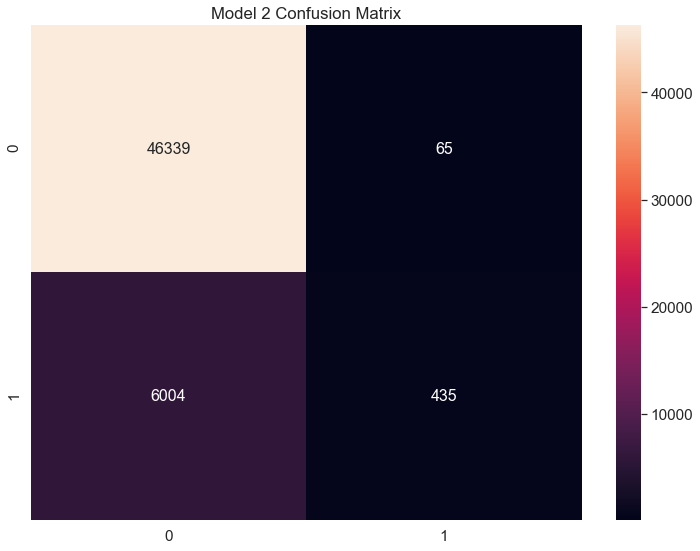

In [26]:
cm2 = pd.DataFrame(confusion_matrix(persons['homeless'], persons['m2_pred']), range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm2, annot=True, annot_kws={'size': 16}, fmt='d') # font size
plt.title('Model 2 Confusion Matrix')

Random Guess: ROC AUC = 0.500
Model 1: ROC AUC = 0.874


Text(0.5, 1.0, 'Model 2 AUC-ROC = 0.874')

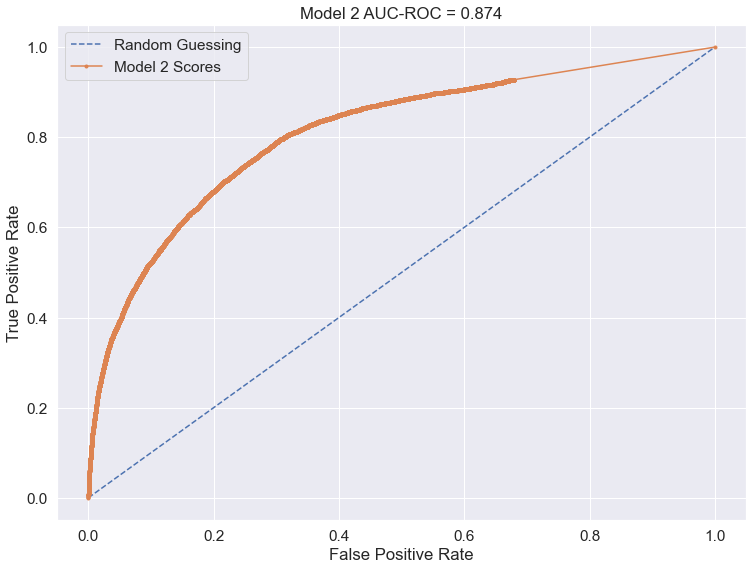

In [27]:
# calculate scores
m2_auc = roc_auc_score(persons['homeless'], persons['m2_pred_prob'])

# summarize scores
print('Random Guess: ROC AUC = %.3f' % (ns_auc))
print('Model 1: ROC AUC = %.3f' % (m2_auc))

# calculate roc curves
m2_fpr, m2_tpr, _ = roc_curve(persons['homeless'], persons['m2_pred_prob'])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Guessing')
plt.plot(m1_fpr, m1_tpr, marker='.', label='Model 2 Scores')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
plt.title('Model 2 AUC-ROC = %.3f' % (m2_auc))